# Exercise 1. Training COSDD<br>
In this section, we will train a COSDD model to remove row correlated and signal-dependent imaging noise. 
You will load noisy data and examine the noise for spatial correlation, then initialise a model and monitor its training.

COSDD is a Ladder VAE with an autoregressive decoder, a type of deep generative model. Deep generative models are trained with the objective of capturing all the structures and characteristics present in a dataset, i.e., modelling the dataset. In our case the dataset will be a collection of noisy microscopy images. 

When COSDD is trained to model noisy images, it exploits differences between the structure of imaging noise and the structure of the clean signal to separate them, capturing each with different components of the model. Specifically, the noise will be captured by the autoregressive decoder and the signal will be captured by the VAE's latent variables. We can then feed an image into the model and sample a latent variable, which will describe the image's clean signal content. This latent variable is then fed through a second network, which was trained alongside the main VAE, to reveal an estimate of the denoised image.

In [1]:
import os
import urllib

import torch
from torchvision import transforms
import tifffile
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import numpy as np

from COSDD import utils
from COSDD.models.lvae import LadderVAE
from COSDD.models.pixelcnn import PixelCNN
from COSDD.models.s_decoder import SDecoder
from COSDD.models.unet import UNet
from COSDD.hub import Hub

%matplotlib inline

In [3]:
use_cuda = torch.cuda.is_available()

### 1.1. Load data

In this example we will be using the Mito Confocal dataset, provided by: <br>
Hagen, G.M., Bendesky, J., Machado, R., Nguyen, T.A., Kumar, T. and Ventura, J., 2021. Fluorescence microscopy datasets for training deep neural networks. GigaScience, 10(5), p.giab032.

<div class="alert alert-info">

### Task 1.1.

In the next cell, the low signal-to-noise ratio data that we will be using in this exercise will be downloaded and storedis stored as a tiff file at `./data/mito-confocal-lowsnr.tif`. 

In the following cell, you'll load it and get it into a format suitable for training the denoiser.

1. Use the function `tifffile.imread` to load the data as a numpy array.
2. Then use np.newaxis to add a channel axis. *Hint* The data is a stack of 2D images, so the channel axis should be the second dimension (dimension 1 if we start counting from zero).
3. Next, use `torch.from_numpy` to convert it into a pytorch tensor.
4. Lastly, convert the datatype to `torch.float32`.
</div>

In [4]:
root_dir = "./data"
if not os.path.exists(root_dir):
    os.mkdir(root_dir)
lowsnr_path = "./data/mito-confocal-lowsnr.tif"
if not os.path.exists(lowsnr_path):
    urllib.request.urlretrieve("https://s3.ap-northeast-1.wasabisys.com/gigadb-datasets/live/pub/10.5524/100001_101000/100888/03-mito-confocal/mito-confocal-lowsnr.tif", lowsnr_path)

In [5]:
# load the data
low_snr = tifffile.imread(lowsnr_path)
low_snr = low_snr[:, np.newaxis]
low_snr = torch.from_numpy(low_snr)
low_snr = low_snr.to(torch.float32)

assert [*low_snr.size()] == [79, 1, 1024, 1024], "Incorrect dimensions"
assert low_snr.dtype == torch.float32, "Incorrect data type"

In [ ]:
# load the data
low_snr = ...
low_snr = ...
low_snr = ...
low_snr = ...

assert [*low_snr.size()] == [79, 1, 1024, 1024], "Incorrect dimensions"
assert low_snr.dtype == torch.float32, "Incorrect data type"

COSDD can handle 1-, 2- and 3-dimensional data, as long as it's loaded as a PyTorch tensor with a batch and channel dimension. For 1D data, it should have dimensions [Number of images, Channels, X], for 2D data: [Number of images, Channels, Y, X] and for 3D: [Number of images, Channels, Z, Y, X]. This applies even if the data has only one channel.

### 1.2. Examine spatial correlation of the noise

This denoiser can remove noise that is correlated along rows or columns of pixels (or not spatially correlated at all). Row or column-correlated noise means that knowing the noise value in one pixel can help us guess the noise value in other pixels in the same row (or column), preventing us from using Noise2Void. Noise correlated along rows of pixels is common in scanning imaging techniques such as scanning confocal microscopy and scanning electron microscopy.

To remove this type of noise, we need to tell the denoiser whether the noise is correlated along rows or along columns. We can establish this by estimating the spatial autocorrelation of the noise. In the context of images, spatial autocorrelation is a measure of what the value of a pixel in one location tells us about the value of pixels in other locations. It is a scale from -1 to +1 and is measured between all pairs of pixel locations. A negative autocorrelation means that the higher the intensity of the one pixel, the lower we should expect the intensity of the other to be. A positive autocorrelation means that the higher the intensity of the one pixel, the higher we should expect the intensity of the other to be. Zero autocorrelation means that the intensity of the one pixel being high or low tells us nothing about whether the intensity of the other will be high or low. 

In [63]:
vmin = np.percentile(low_snr, 1)
vmax = np.percentile(low_snr, 99)

<div class="alert alert-info">

### Task 1.2.

To estimate the spatial correlation of the noise, we need a sample of pure noise. This can be a patch of `low_snr` with no signal. Adjust the values for `img_idx`, `top`, `bottom`, `left` and `right` to explore slices of the data and identify a suitable dark patch. When decided, set the `dark_patch` in the following cell and pass it as an argument to `utils.autocorrelation`, then plot the result. 

*Hint: The bigger the dark patch, the more accurate our estimate of the spatial autocorrelation will be.*
</div>

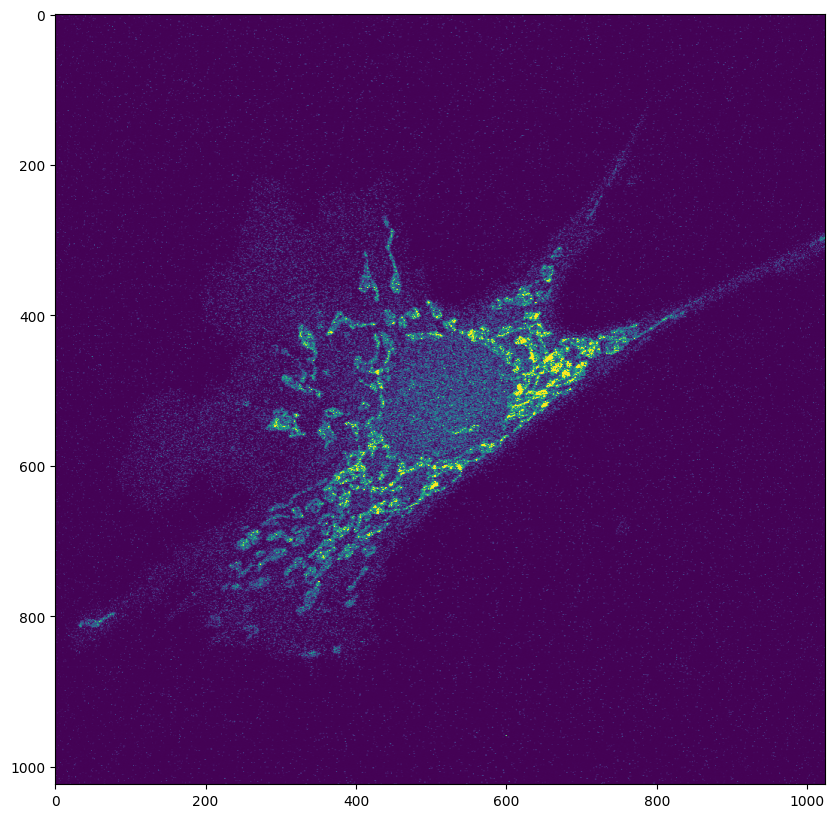

In [66]:
### Explore slices of the data here
img_idx = 8
top = 0
bottom = 1024
left = 0
right = 1024

crop = (img_idx, 0, slice(top, bottom), slice(left, right))

plt.figure(figsize=(10, 10))
plt.imshow(low_snr[crop], vmin=vmin, vmax=vmax)
plt.show()

In [ ]:
### Define the crop of the dark image patch here
dark_img_idx = ...
dark_top = ...
dark_bottom = ...
dark_left = ...
dark_right = ...

dark_crop = (dark_img_idx, 0, slice(dark_top, dark_bottom), slice(dark_left, dark_right))
dark_patch = low_snr[dark_crop]

noise_ac = utils.autocorrelation(dark_patch, max_lag=25)

In [49]:
### Define the crop of the dark image patch here
dark_img_idx = 8
dark_top = 800
dark_bottom = 1024
dark_left = 800
dark_right = 1024

dark_crop = (dark_img_idx, 0, slice(dark_top, dark_bottom), slice(dark_left, dark_right))
dark_patch = low_snr[dark_crop]

noise_ac = utils.autocorrelation(dark_patch, max_lag=25)

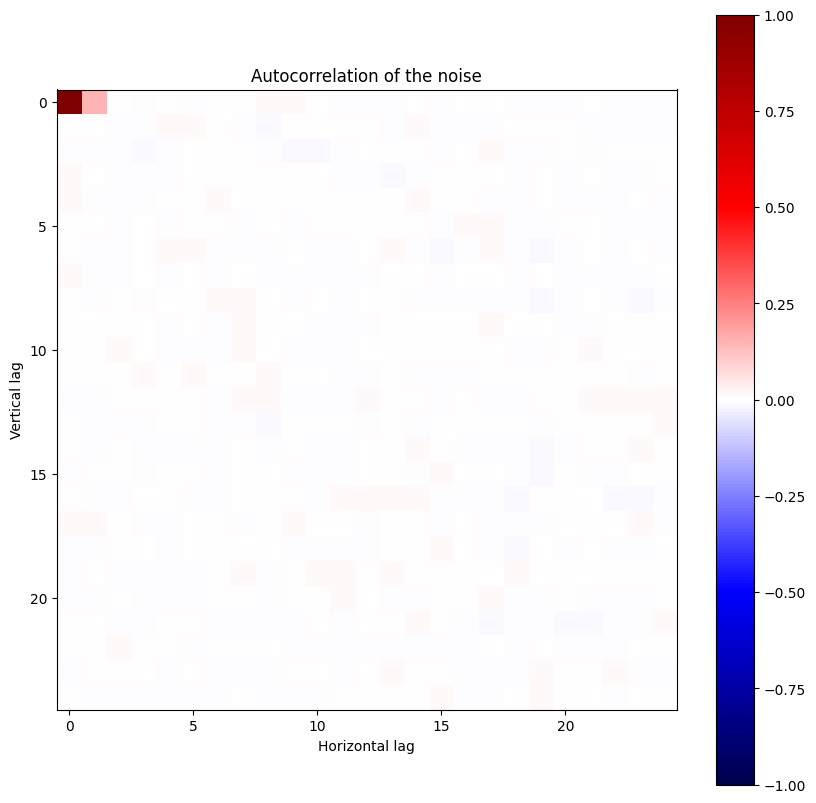

In [61]:
# Plot the autocorrelation
plt.figure(figsize=(10, 10))
plt.imshow(noise_ac, cmap="seismic", vmin=-1, vmax=1)
plt.colorbar()
plt.title("Autocorrelation of the noise")
plt.xlabel("Horizontal lag")
plt.ylabel("Vertical lag")
plt.show()

This is a two dimensional plot describing the linear relationship between pixel values at different locations. The colour of a square is the value of the autocorrelation between pixels separated by the horizontal and vertical lag. For example, the colour of the square at a horizontal lag of 5 and a vertical lag of 10 tells us that if we looked at the value any one pixel in the image, then counted 5 pixels to the right and 10 pixels down, what value should we expect the pixel we land on to be. Correlation is symetric, so we can expect the same if we counted left or up.

In this plot, all of the squares should be white, except for the top row. The autocorrelation of the square at (0, 0) will always be 1.0, as a pixel's value will always be perfectly correlated with itself. We define this type of noise as correlated along the x axis.

To remove this type of noise, the autoregressive decoder of our VAE must have a receptive field spanning the x axis.
Note that if the data contained spatially *un*correlated noise, we can still remove it, as the decoder's receptive field will become redundant.

### 1.3. Create training and validation dataloaders

The data will be fed to the model by two dataloaders, `train_loader` and `val_loader`, for the training and validation set respectively. <br>
In this example, 90% of images will be used for training and the remaining 10% for validation.

`real_batch_size` (int) Number of images passed through the network at a time. <br>
`n_grad_batches` (int) Number of batches to pass through the network before updating parameters.<br>
`crop_size` (tuple(int)): The size of randomly cropped patches. Should be less than the dimensions of your images.<br>
`train_split` (0 < float < 1): Fraction of images to be used in the training set, with the remainder used for the validation set.


In [67]:
real_batch_size = 4
n_grad_batches = 4
print(f"Effective batch size: {real_batch_size * n_grad_batches}")
crop_size = (256, 256)
train_split = 0.9

n_iters = np.prod(low_snr.shape[2:]) // np.prod(crop_size)
transform = utils.RandomCrop(crop_size)

dataset = utils.TrainDataset(low_snr, n_iters=n_iters, transform=transform)
train_set, val_set = torch.utils.data.random_split(dataset, [train_split, 1-train_split])
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=real_batch_size, shuffle=True, pin_memory=True, num_workers=7,
)
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=real_batch_size, shuffle=False, pin_memory=True, num_workers=7,
)

Effective batch size: 16


### 1.4. Create the model

The model we will train to denoise consists of four modules, with forth being the optional Direct Denoiser which we can train if we want to speed up inference. Each module is listed below with an explanation of their hyperparameters.

`lvae` The ladder variational autoencoder that will output latent variables.<br>
* `s_code_channels` (int): Number of channels in outputted latent variable.
* `n_layers` (int): Number of levels in the ladder vae.
* `z_dims` (list(int)): List with the numer of latent space dimensions at each level of the hierarchy. List starts from the input/output level and works down.
* `downsampling` (list(int)): Binary list of whether to downsample at each level of the hierarchy. 1 for do and 0 for don't.

`ar_decoder` The autoregressive decoder that will decode latent variables into a distribution over the input.<br>
* `kernel_size` (int): Length of 1D convolutional kernels.
* `noise_direction` (str): Axis along which noise is correlated: `"x"`, `"y"` or `"z"`. This needs to match the orientation of the noise structures we revealed in the autocorrelation plot in Part 2.
* `n_filters` (int): Number of feature channels.
* `n_gaussians` (int): Number of components in Gaussian mixture used to model data.

`s_decoder` A decoder that will map the latent variables into image space, giving us a denoised image. <br>
* `n_filters` (int): The number of feature channels.<br>

`direct_denoiser` The U-Net that can optionally be trained to predict the MMSE or MMAE of the denoised images. This will slow training slightly but massively speed up inference and is worthwile if you have an inference dataset in the gigabytes. See [this paper](https://arxiv.org/abs/2310.18116). Enable or disable the direct denoiser by setting `use_direct_denoiser` to `True` or `False`.
* `n_filters` (int): Feature channels at each level of UNet. Defaults to `s_code_channel`.
* `n_layers` (int): Number of levels in the UNet. Defaults to the number of levels in the `LadderVAE`.
* `downsampling` (list(int)): Binary list of whether to downsample at each level of the hierarchy. 1 for do and 0 for don't. Also defaults to match the `LadderVAE`.
* `loss_fn` (str): Whether to use `"L1"` or `"L2"` loss function to predict either the mean or pixel-wise median of denoised images respectively.

`hub` The hub that will unify and train the above modules.
* `n_grad_batches` (int): Number of batches to accumulate gradients for before updating weights of all models. If the real batch or random crop size has been reduced to lower memory consumption, increase this value for the effective batch size to stay the same.
* `checkpointed` (bool): Whether to use activation checkpointing during training. This reduces memory consumption but increases training time. 

<div class="alert alert-info">

### Task 1.3.

Most hyperparameters have been set to recommended values for a small sized model. The two that have been left blank are `noise_direction` under the `ar_decoder`, and `use_direct_denoiser`. Use the above description of what each hyperparameter means to determine the best value for each of these.

*Hint: enabling the Direct Denoiser will give us additional results to look at in the next notebook.*

</div>

In [ ]:
s_code_channels = 64

n_layers = 6
z_dims = [s_code_channels // 2] * n_layers
downsampling = [1] * n_layers
lvae = LadderVAE(
    colour_channels=low_snr.shape[1],
    img_size=crop_size,
    s_code_channels=s_code_channels,
    n_filters=s_code_channels,
    z_dims=z_dims,
    downsampling=downsampling,
)

ar_decoder = PixelCNN(
    colour_channels=low_snr.shape[1],
    s_code_channels=s_code_channels,
    kernel_size=5,
    noise_direction=...,  ### Insert a value here
    n_filters=64,
    n_layers=4,
    n_gaussians=8,
)

s_decoder = SDecoder(
    colour_channels=low_snr.shape[1],
    s_code_channels=s_code_channels,
    n_filters=s_code_channels,
)

use_direct_denoiser = ...  ### Insert a value here
if use_direct_denoiser:
    direct_denoiser = UNet(
        colour_channels=low_snr.shape[1],
        n_filters=s_code_channels,
        n_layers=n_layers,
        downsampling=downsampling,
        loss_fn="L2",
    )
else:
    direct_denoiser = None

hub = Hub(
    vae=lvae,
    ar_decoder=ar_decoder,
    s_decoder=s_decoder,
    direct_denoiser=direct_denoiser,
    data_mean=low_snr.mean(),
    data_std=low_snr.std(),
    n_grad_batches=n_grad_batches,
    checkpointed=True,
)

# Show the model the dimensionality of the data to initialise its parameters
a = next(iter(train_loader))
with torch.no_grad():
    _ = hub(a)

In [ ]:
s_code_channels = 64

n_layers = 6
z_dims = [s_code_channels // 2] * n_layers
downsampling = [1] * n_layers
lvae = LadderVAE(
    colour_channels=low_snr.shape[1],
    img_size=crop_size,
    s_code_channels=s_code_channels,
    n_filters=s_code_channels,
    z_dims=z_dims,
    downsampling=downsampling,
)

ar_decoder = PixelCNN(
    colour_channels=low_snr.shape[1],
    s_code_channels=s_code_channels,
    kernel_size=5,
    noise_direction="x",  ### Insert a value here
    n_filters=64,
    n_layers=4,
    n_gaussians=8,
)

s_decoder = SDecoder(
    colour_channels=low_snr.shape[1],
    s_code_channels=s_code_channels,
    n_filters=s_code_channels,
)

use_direct_denoiser = True  ### Insert a value here
if use_direct_denoiser:
    direct_denoiser = UNet(
        colour_channels=low_snr.shape[1],
        n_filters=s_code_channels,
        n_layers=n_layers,
        downsampling=downsampling,
        loss_fn="L2",
    )
else:
    direct_denoiser = None

hub = Hub(
    vae=lvae,
    ar_decoder=ar_decoder,
    s_decoder=s_decoder,
    direct_denoiser=direct_denoiser,
    data_mean=low_snr.mean(),
    data_std=low_snr.std(),
    n_grad_batches=n_grad_batches,
    checkpointed=True,
)

# Show the model the dimensionality of the data to initialise its parameters
a = next(iter(train_loader))
with torch.no_grad():
    _ = hub(a)

### 1.5. Train the model

<div class="alert alert-info">

### Task 1.4.

We're going to use Tensorboard to monitor training metrics. Run the two cells below to open tensorboard in the notebook. If it doesn't work, follow the steps below to open it in a browser.

1. Open a terminal.
2. Enter `conda activate 05_image_restoration` to activate an environment with Tensorboard installed.
3. Enter `tensorboard --logdir 05_image_restoration/03_COSDD/checkpoints`
4. Finally, open a browser and enter localhost:6006 in the address bar.
</div>

#### Tensorboard metrics

In the SCALARS tab, there will be 4 metrics to track (5 if direct denoiser is enabled). These are:<br>
1. `kl_loss` The Kullback-Leibler divergence between the VAE's approximate posterior and its prior. This can be thought of as a measure of how much information about the input image is going into the VAE's latent variables. We want information about the input's underlying clean signal to go into the latent variables, so this metric shouldn't go all the way to zero. Instead, it can typically go either up or down during training before plateauing.<br>
2. `reconstruction_loss` The negative log-likelihood of the AR decoder's predicted distribution given the input data. This is how accurately the AR decoder is able to predict the input. This value can go below zero and should decrease throughout training before plateauing.<br>
3. `elbo` The Evidence Lower Bound, which is the total loss of the main VAE. This is the sum of the kl and reconstruction loss and should decrease throughout training before plateauing.<br>
4. `sd_loss` The mean squared error between the noisy image and the image predicted by the signal decoder. This metric should steadily decrease towards zero without ever reaching it. Sometimes the loss will not go down for the first few epochs because its input (produced by the VAE) is rapidly changing. This is ok and the loss should start to decrease when the VAE stabilises. <br>
5. `dd_loss` The mean squared error between the output of the direct denoiser and the clean images predicted by the signal decoder. This will only be present if `use_direct_denoiser` is set to `True`. The metric should steadily decrease towards zero without ever reaching it, but may be unstable at the start of training as its targets (produced by the signal decoder) are rapidly changing.

There will also be an IMAGES tab. This shows noisy input images from the validation set and some outputs. These will be two randomly sampled denoised images (sample 1 and sample 2), the average of ten denoised images (mmse) and if the direct denoiser is enabled, its output (direct estimate).

If noise has not been fully removed from the output images, try increasing `n_gaussians` argument of the AR decoder. This will give it more flexibility to model complex noise characteristics. However, setting the value too high can lead to unstable training. Typically, values from 3 to 5 work best.

Note that the trainer is set to train for only 20 minutes in this example. Remove the line with `max_time` to train fully.

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir checkpoints/

<div class="alert alert-info">

### Task 1.5.

Now the model is ready to start training. Give the model a sensible name by setting `model_name` to a string then run the following cells.

The `max_time` parameter in the cell below means we'll only train the model for 20 minutes, just to get idea of what to expect. In the future, to remove the time restriction, the `max_time` parameter can be set to `None`.
</div>

`model_name` (str): Should be set to something appropriate so that the trained parameters can be used later for inference.<br>
`max_epochs` (int): The number of training epochs.<br>
`patience` (int): If the validation loss has plateaued for this many epochs, training will stop.

In [ ]:
model_name = ...  ### Insert a value here
checkpoint_path = os.path.join("checkpoints", model_name)
logger = TensorBoardLogger(checkpoint_path)

max_epochs = 1000
max_time = "00:00:20:00"
patience = 100

trainer = pl.Trainer(
    logger=logger,
    accelerator="gpu" if use_cuda else "cpu",
    devices=1,
    max_epochs=max_epochs,
    max_time=max_time,  # Remove this time limit to train the model fully
    log_every_n_steps=len(train_set) // (4 * real_batch_size),
    callbacks=[EarlyStopping(patience=patience, monitor="val/elbo")],
    precision="bf16-mixed" if use_cuda else 32,
)

In [ ]:
model_name = "mito-confocal"  ### Insert a value here
checkpoint_path = os.path.join("checkpoints", model_name)
logger = TensorBoardLogger(checkpoint_path)

max_epochs = 1000
max_time = "00:00:20:00"
patience = 100

trainer = pl.Trainer(
    logger=logger,
    accelerator="gpu" if use_cuda else "cpu",
    devices=1,
    max_epochs=max_epochs,
    max_time=max_time,  # Remove this time limit to train the model fully
    log_every_n_steps=len(train_set) // (4 * real_batch_size),
    callbacks=[EarlyStopping(patience=patience, monitor="val/elbo")],
    precision="bf16-mixed" if use_cuda else 32,
)

In [ ]:
trainer.fit(hub, train_loader, val_loader)
trainer.save_checkpoint(os.path.join(checkpoint_path, "final_model.ckpt"))

<div class="alert alert-success">

## Checkpoint 1
We've now trained a COSDD model to denoise our data. Continue to the next notebook, exercise-2-prediction.ipynb, to use it to get some results.

</div>